In [24]:
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
import json
import random

In [45]:
img1 = skimage.io.imread('p0.png')
img1 = img1[200:900, 400:1100, :]
skimage.io.imsave("d/img1.jpg", img1)
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

des1 = np.array([corners[:,1], corners[:,0]]).astype(int).T
# des1 = [
# [ 96, 378],
# [111, 320],
# [112, 435],
# [129, 375],


# [305, 201],
# [376, 207],
# [333, 251],
# [406, 256],

# [335, 496],
# [408, 492],
# [307, 550],
# [379, 545]]
for x in range(len(des1)):
  for a in range(5):
    for b in range(5):
      img1[des1[x][0]-2+a][des1[x][1]-2+b]=[0,0,255]


cv2.imshow('dst',img1)
cv2.waitKey(0)

-1

In [27]:
img2 = skimage.io.imread('p1.png')
img2 = img2[200:900, 400:1100, :]
skimage.io.imsave("d/img2.jpg", img2)
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

des2 = np.array([corners[:,1], corners[:,0]]).astype(int).T
# des2 = [
# [ 96, 396],
# [107, 326],
# [120, 432],
# [132, 354],
# [277, 185],
# [343, 191],
# [311, 205],
# [381, 212],
# [355, 426],
# [427, 424],
# [337, 502],
# [408, 499]]
for x in range(len(des2)):
  for a in range(5):
    for b in range(5):
      img2[des2[x][0]-2+a][des2[x][1]-2+b]=[0,0,255]

cv2.imshow('dst',img2)
cv2.waitKey(0)

-1

In [28]:
def factorization_method(points_im1, points_im2):
    c1 = np.zeros(2)
    for x in range(len(points_im1)):
        c1[0] += points_im1[x][0]
        c1[1] += points_im1[x][1]
    c1 /= len(points_im1)
    pc1 = []
    for x in range(len(points_im1)):
        pc1.append([points_im1[x][0] - c1[0], points_im1[x][1] - c1[1], 1])
    pc1 = np.array(pc1)
    c2 = np.zeros(2)
    for x in range(len(points_im2)):
        c2[0] += points_im2[x][0]
        c2[1] += points_im2[x][1]
    c2 /= len(points_im2)
    pc2 = []
    for x in range(len(points_im2)):
        pc2.append([points_im2[x][0] - c2[0], points_im2[x][1] - c2[1], 1])
    pc2 = np.array(pc2)

    D = np.matrix(np.concatenate((np.transpose(pc1)[0:2], np.transpose(pc2)[0:2])))
    u, s, vh = np.linalg.svd(D, full_matrices=False)
    s = s[0:3]
    u = u[:,0:3]
    vh = vh[0:3]
    structure = np.matmul(np.diag(s),vh)
    motion = u
    return structure, motion

In [29]:
def get_data_from_txt_file(filename, use_subset = False):
    with open(filename) as f:
            lines = f.read().splitlines() 
    number_pts = int(lines[0])

    points = np.ones((number_pts, 3))
    for i in range(number_pts):
        split_arr = lines[i+1].split()
        if len(split_arr) == 2:
            y, x = split_arr
        else:
            x, y, z = split_arr
            points[i,2] = z
        points[i,0] = x 
        points[i,1] = y
    return points

In [30]:
points_img1 = get_data_from_txt_file('des1.txt')
points_img2 = get_data_from_txt_file('des2.txt')
structure, motion = factorization_method(points_img1, points_img2)

In [31]:
def scatter_3D_axis_equal(X, Y, Z, ax):
    ax.scatter(X, Y, Z)
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

Text(0.5, 0.92, 'Factorization Method')

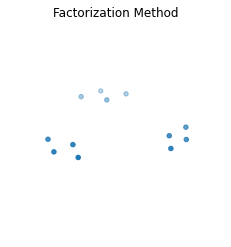

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.axis('off')
scatter_3D_axis_equal(structure[0,:], structure[1,:], structure[2,:], ax)
ax.set_title('Factorization Method')

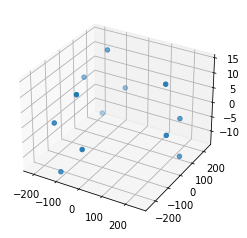

In [33]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(structure[0,:], structure[1,:], structure[2,:])
plt.show()

In [34]:
def estimate_initial_RT(E):
    U, D, VT = np.linalg.svd(E, full_matrices=False)
    T = U[:,2:3]
    W = np.matrix([[0,-1,0],[1,0,0],[0,0,1]])
    Q1 = np.matmul(np.matmul(U, W), VT)
    Q2 = np.matmul(np.matmul(U, W.T), VT)
    R1 = np.linalg.det(Q1) * Q1
    R2 = np.linalg.det(Q2) * Q2
    RTs = []
    RTs.append(np.concatenate((R1, T),axis=1))
    RTs.append(np.concatenate((R1, -T),axis=1))
    RTs.append(np.concatenate((R2, T),axis=1))
    RTs.append(np.concatenate((R2, -T),axis=1))
    return np.array(RTs)
def linear_estimate_3d_point(image_points, camera_matrices):
    A = []
    for x in range(len(image_points)):
        A.append(image_points[x][0] * camera_matrices[x][2] - camera_matrices[x][0])
        A.append(image_points[x][1] * camera_matrices[x][2] - camera_matrices[x][1])
    U, D, VT = np.linalg.svd(A, full_matrices=False)
    solve =  VT[-1]
    return solve[0:3] / solve[3]
def jacobian(point_3d, camera_matrices):
    J = np.zeros((2*camera_matrices.shape[0], 3))
    point_3d_homo = np.hstack((point_3d, 1))
    J_set = []

    for i in range(camera_matrices.shape[0]):
        Mi = camera_matrices[i]
        pi = Mi.dot(point_3d_homo)
        Jix = (pi[2]*np.array([Mi[0, 0], Mi[0, 1], Mi[0, 2]]) \
              - pi[0]*np.array([Mi[2, 0], Mi[2, 1], Mi[2, 2]])) / pi[2]**2
        Jiy = (pi[2]*np.array([Mi[1, 0], Mi[1, 1], Mi[1, 2]]) \
              - pi[1]*np.array([Mi[2, 0], Mi[2, 1], Mi[2, 2]])) / pi[2]**2
        J_set.append(Jix)
        J_set.append(Jiy)

    for i in range(J.shape[0]):
        J[i] = J_set[i]
    return J
def reprojection_error(point_3d, image_points, camera_matrices):
    N = image_points.shape[0]
    error_set = []
    point_3d_homo = np.hstack((point_3d, 1))

    for i in range(N):
        pi = image_points[i]
        Mi = camera_matrices[i]
        Yi = Mi.dot(point_3d_homo)
        # compute error
        pi_prime = 1.0 / Yi[2] * np.array([Yi[0], Yi[1]])
        error_i = (pi_prime - pi)
        error_set.append(error_i[0])
        error_set.append(error_i[1])

    error = np.array(error_set)
    return error
def nonlinear_estimate_3d_point(image_points, camera_matrices):
    P = linear_estimate_3d_point(image_points, camera_matrices)

    for i in range(10):
        e = reprojection_error(P, image_points, camera_matrices)
        J = jacobian(P, camera_matrices)
        P -= np.linalg.inv(J.T.dot(J)).dot(J.T).dot(e)

    return P
def estimate_RT_from_E(E, image_points, K):
    # TODO: Implement this method!
    RT = estimate_initial_RT(E)
    N = image_points.shape[0]
    for i in range(4):
        count = 0
        max_points = 0
        rt = RT[i, :, :]
        c1 = np.c_[K, np.zeros((3,1))]
        c2 = K.dot(rt)
        camera_matrices = np.array([c1, c2])
        for j in range(N):
            estimated_point = nonlinear_estimate_3d_point(image_points[j], camera_matrices)
            if (estimated_point[2]) > 0:
                count += 1
        if count > max_points:
            max_points = count
            correct_RT = RT[i, :, :]
    return correct_RT

In [35]:
camera_matrices = np.zeros((2, 3, 4))
camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))

NameError: name 'K' is not defined